In [1]:
import sqlalchemy as db
from sqlalchemy import func, text
from sqlalchemy import func
from sqlalchemy import alias
import pandas as pd
import numpy as np
import pprint as pprint
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
from sqlalchemy import create_engine
engine = db.create_engine('sqlite:///database.sqlite')
connection = engine.connect()
metadata = db.MetaData()

## 1. What was the total spent on salaries by each team, each year?

In [3]:
df_salaries = pd.read_csv('baseballdatabank-master/core/salaries.csv')
df_salaries.to_sql('tbl_salaries', engine, if_exists='replace')
tbl_salaries = db.Table('tbl_salaries', metadata, autoload=True, autoload_with=engine)

In [4]:
print(tbl_salaries.columns.keys())

['index', 'yearID', 'teamID', 'lgID', 'playerID', 'salary']


In [5]:
query = db.select([tbl_salaries.columns.yearID, tbl_salaries.columns.teamID, \
                   func.sum(tbl_salaries.columns.salary).label('payroll')])
query = query.select_from(tbl_salaries)
query = query.group_by(tbl_salaries.columns.yearID, tbl_salaries.columns.teamID)
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,yearID,teamID,payroll
0,1985,ATL,14807000
1,1985,BAL,11560712
2,1985,BOS,10897560
3,1985,CAL,14427894
4,1985,CHA,9846178


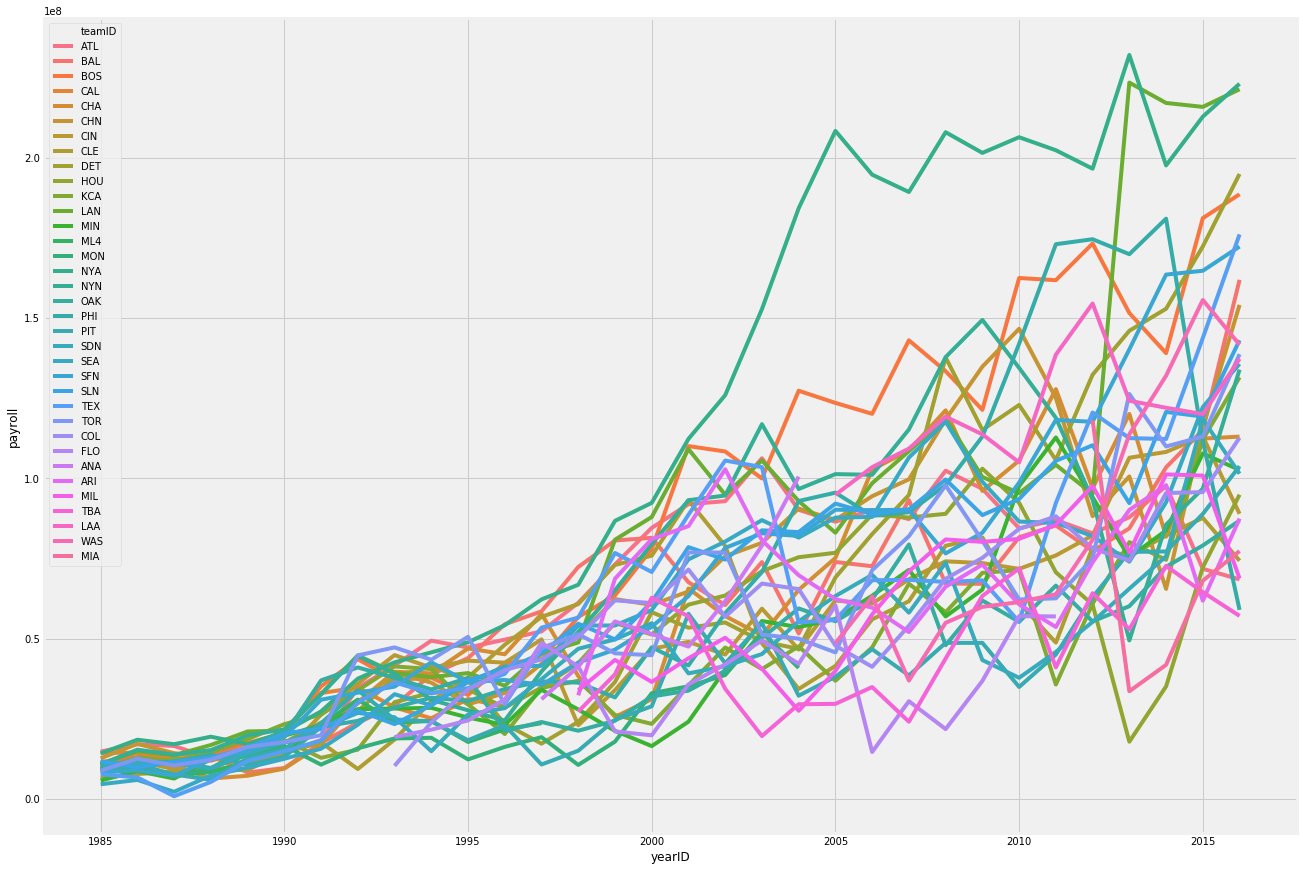

In [6]:
plt.subplots(figsize=(20,15))
sns.lineplot(x='yearID', y='payroll', data=df, hue='teamID')

In [7]:
# salaries_by_year = (salaries.groupby(['yearID', 'teamID'], as_index=False)
#                                            .agg(OrderedDict(
#                                                    [('salary','sum')])))


In [8]:
# salaries_by_year.head()

In [9]:
# plt.subplots(figsize=(20,15))
# sns.lineplot(x='yearID', y='salary', data=salaries_by_year, hue='teamID')

## 2. What is the first and last year played for each player? Hint: Create a new table from 'Fielding.csv'.

In [10]:
df_fielding = pd.read_csv('baseballdatabank-master/core/Fielding.csv')
df_fielding.to_sql('tbl_fielding', engine, if_exists='replace')
tbl_fielding = db.Table('tbl_fielding', metadata, autoload=True, autoload_with=engine)

In [11]:
df_people = pd.read_csv('baseballdatabank-master/core/People.csv')
df_people.to_sql('tbl_people', engine, if_exists='replace')
tbl_people = db.Table('tbl_people', metadata, autoload=True, autoload_with=engine)

In [12]:
print(tbl_fielding.columns.keys())

['index', 'playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR']


In [13]:
print(tbl_people.columns.keys())

['index', 'playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame', 'retroID', 'bbrefID']


In [14]:
query = db.select([tbl_fielding.columns.playerID, \
                   tbl_people.columns.nameFirst, tbl_people.columns.nameLast, \
                   func.min(tbl_fielding.columns.yearID).label('first_year'), \
                   func.max(tbl_fielding.columns.yearID).label('last_year')])
query = query.select_from(tbl_fielding.join(tbl_people, tbl_fielding.columns.playerID == tbl_people.columns.playerID))
query = query.select_from(tbl_fielding)
query = query.group_by(tbl_fielding.columns.playerID)
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,playerID,nameFirst,nameLast,first_year,last_year
0,aardsda01,David,Aardsma,2004,2015
1,aaronha01,Hank,Aaron,1954,1976
2,aaronto01,Tommie,Aaron,1962,1971
3,aasedo01,Don,Aase,1977,1990
4,abadan01,Andy,Abad,2001,2003


## 3. Who has played the most all star games?

In [15]:
df_allstar = pd.read_csv('baseballdatabank-master/core/AllstarFull.csv')
df_allstar.to_sql('tbl_allstar', engine, if_exists='replace')
tbl_allstar = db.Table('tbl_allstar', metadata, autoload=True, autoload_with=engine)

In [16]:
print(tbl_allstar.columns.keys())

['index', 'playerID', 'yearID', 'gameNum', 'gameID', 'teamID', 'lgID', 'GP', 'startingPos']


In [17]:
query = db.select([tbl_allstar.columns.playerID, \
                   tbl_people.columns.nameFirst, tbl_people.columns.nameLast, \
                   func.count(tbl_allstar.columns.yearID).label('num_appearances')])
query = query.select_from(tbl_allstar.join(tbl_people, tbl_allstar.columns.playerID == tbl_people.columns.playerID))
query = query.group_by(tbl_allstar.columns.playerID)
query = query.order_by(func.count(tbl_allstar.columns.yearID).desc())
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,playerID,nameFirst,nameLast,num_appearances
0,aaronha01,Hank,Aaron,25
1,mayswi01,Willie,Mays,24
2,musiast01,Stan,Musial,24
3,mantlmi01,Mickey,Mantle,20
4,ripkeca01,Cal,Ripken,19


Hank Aaron played in 25 (!) All-Star games.

## 4. Which school has generated the most distinct players? Hint: Create new table from 'CollegePlaying.csv'.

In [18]:
df_college = pd.read_csv('baseballdatabank-master/core/CollegePlaying.csv')
df_college.to_sql('tbl_college', engine, if_exists='replace')
tbl_college = db.Table('tbl_college', metadata, autoload=True, autoload_with=engine)

In [19]:
print(tbl_college.columns.keys())

['index', 'playerID', 'schoolID', 'yearID']


In [20]:
query = db.select([tbl_college.columns.schoolID, \
                   tbl_college.columns.playerID,
                   func.count(tbl_college.columns.yearID).label('years')])
query = query.select_from(tbl_college)
query = query.group_by(tbl_college.columns.schoolID, tbl_college.columns.playerID)
query = query.order_by(func.count(tbl_college.columns.playerID).asc())
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head()

,schoolID,playerID,years
0,akron,dilauja01,1
1,akron,nealejo01,1
2,alabama,dunnji01,1
3,alabama,freemhe01,1
4,alabama,huntra01,1


In [21]:
print(df.schoolID.value_counts()[0:5])

texas        107
usc          105
arizonast    101
stanford      86
michigan      76
Name: schoolID, dtype: int64


Texas has produced the most players (107).

## 5. Which players have the longest career? Assume that the debut and finalGame columns comprise the start and end, respectively, of a player's career. Hint: Create a new table from 'Master.csv'. Also note that strings can be converted to dates using the DATE function and can then be subtracted from each other yielding their difference in days.

In [22]:
query = db.select([tbl_people.columns.playerID,
                   tbl_people.columns.nameFirst, tbl_people.columns.nameLast, 
                   tbl_people.columns.debut.label('debut'),
                   tbl_people.columns.finalGame.label('final'),
                   func.date(tbl_people.columns.debut).label('debut2'),
                   func.date(tbl_people.columns.finalGame).label('final2'),
                   (func.date(tbl_people.columns.finalGame) - \
                        func.date(tbl_people.columns.debut)).label('diff'),
                   func.extract('month', tbl_people.columns.debut).label('month')])
query = query.select_from(tbl_people)
query = query.group_by(tbl_people.columns.playerID)
query = query.order_by(func.count(tbl_people.columns.playerID).asc())
results = connection.execute(query).fetchall()
df_people_dates = pd.DataFrame(results)
df_people_dates.columns = results[0].keys()
df_people_dates.head()

,playerID,nameFirst,nameLast,debut,final,debut2,final2,diff,month
0,aardsda01,David,Aardsma,2004-04-06,2015-08-23,2004-04-06,2015-08-23,11.0,4.0
1,aaronha01,Hank,Aaron,1954-04-13,1976-10-03,1954-04-13,1976-10-03,22.0,4.0
2,aaronto01,Tommie,Aaron,1962-04-10,1971-09-26,1962-04-10,1971-09-26,9.0,4.0
3,aasedo01,Don,Aase,1977-07-26,1990-10-03,1977-07-26,1990-10-03,13.0,7.0
4,abadan01,Andy,Abad,2001-09-10,2006-04-13,2001-09-10,2006-04-13,5.0,9.0


In [23]:
df_people_dates['debut'] = df_people_dates.apply(lambda x:
                                            pd.to_datetime(x['debut']), 
                                            axis=1)
df_people_dates['final'] = df_people_dates.apply(lambda x:
                                            pd.to_datetime(x['final']), 
                                            axis=1)
df_people_dates['days'] = df_people_dates.apply(lambda x:
                                            x['final'] - x['debut'], 
                                            axis=1)
df_people_dates['years'] = df_people_dates.apply(lambda x:
                                            round(float((x['days'] / 
                                                np.timedelta64(1, 'D'))/365.25), 2), 
                                            axis=1)

In [24]:
df_people_dates = df_people_dates.sort_values(by=['days'], ascending=False)
df_people_dates = df_people_dates.dropna()

In [25]:
df_people_dates.head(15)

,playerID,nameFirst,nameLast,debut,final,debut2,final2,diff,month,days,years
272,altroni01,Nick,Altrock,1898-07-14,1933-10-01,1898-07-14,1933-10-01,35.0,7.0,12862 days,35.21
13075,orourji01,Jim,O'Rourke,1872-04-26,1904-09-22,1872-04-26,1904-09-22,32.0,4.0,11836 days,32.41
11938,minosmi01,Minnie,Minoso,1949-04-19,1980-10-05,1949-04-19,1980-10-05,31.0,4.0,11492 days,31.46
12973,olearch01,Charley,O'Leary,1904-04-14,1934-09-30,1904-04-14,1934-09-30,30.0,4.0,11126 days,30.46
9799,lathaar01,Arlie,Latham,1880-07-05,1909-09-30,1880-07-05,1909-09-30,29.0,7.0,10678 days,29.23
11391,mcguide01,Deacon,McGuire,1884-06-21,1912-05-18,1884-06-21,1912-05-18,28.0,6.0,10192 days,27.90
8561,jennihu01,Hughie,Jennings,1891-06-01,1918-09-02,1891-06-01,1918-09-02,27.0,6.0,9954 days,27.25
5204,eversjo01,Johnny,Evers,1902-09-01,1929-10-06,1902-09-01,1929-10-06,27.0,9.0,9897 days,27.10
15235,ryanno01,Nolan,Ryan,1966-09-11,1993-09-22,1966-09-11,1993-09-22,27.0,9.0,9873 days,27.03
16888,streega01,Gabby,Street,1904-09-13,1931-09-20,1904-09-13,1931-09-20,27.0,9.0,9868 days,27.02


Clearly, careers used to last much longer a century ago. 35 years is a *very* long career! <br>
Far fewer of them are recent (Nolan Ryan, Jamie Moyer, and Julio Franco, who seemed to play *forever*).

## 6. What is the distribution of debut months? Hint: Look at the DATE and EXTRACT functions.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


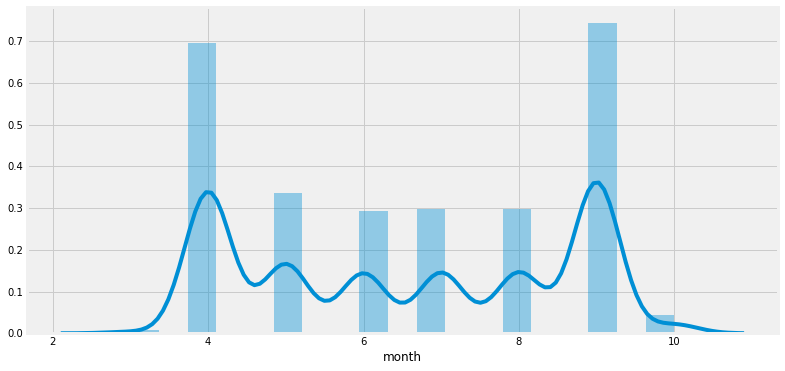

In [26]:
plt.subplots(figsize=(12,6))
sns.distplot(df_people_dates['month'])

## 7. What is the effect of table join order on mean salary for the players listed in the main (master) table? Hint: Perform two different queries, one that joins on playerID in the salary table and other that joins on the same column in the master table. You will have to use left joins for each since right joins are not currently supported with SQLalchemy.

In [54]:
print(tbl_fielding.columns.keys())

['index', 'playerID', 'yearID', 'stint', 'teamID', 'lgID', 'POS', 'G', 'GS', 'InnOuts', 'PO', 'A', 'E', 'DP', 'PB', 'WP', 'SB', 'CS', 'ZR']


In [47]:
print(tbl_salaries.columns.keys())

['index', 'yearID', 'teamID', 'lgID', 'playerID', 'salary']


In [43]:
query = db.select([tbl_salaries.columns.playerID, \
                   func.avg(tbl_salaries.columns.salary).label('mean_salary'),
                  func.count(tbl_salaries.columns.yearID).label('num_seasons')])
query = query.select_from(tbl_salaries)
query = query.group_by(tbl_salaries.columns.playerID)
query = query.order_by(func.avg(tbl_salaries.columns.salary).desc())
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,playerID,mean_salary,num_seasons
0,tanakma01,2.200000e+07,3
1,rodrial01,1.810983e+07,22
2,howarry01,1.552550e+07,10
3,teixema01,1.530536e+07,14
4,sabatcc01,1.457619e+07,15


In [56]:
query = db.select([tbl_salaries.columns.playerID,
                   func.avg(tbl_salaries.columns.salary).label('mean_salary'),
                  func.count(tbl_salaries.columns.yearID).label('num_seasons')])
query = query.select_from(tbl_salaries.join(tbl_fielding, tbl_salaries.columns.playerID == tbl_fielding.columns.playerID))
query = query.group_by(tbl_salaries.columns.playerID)
query = query.order_by(func.avg(tbl_salaries.columns.salary).desc())
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,playerID,mean_salary,num_seasons
0,tanakma01,2.200000e+07,12
1,rodrial01,1.810983e+07,550
2,howarry01,1.552550e+07,130
3,teixema01,1.530536e+07,266
4,sabatcc01,1.457619e+07,270


In [57]:
query = db.select([tbl_fielding.columns.playerID,
                   func.avg(tbl_salaries.columns.salary).label('mean_salary'),
                  func.count(tbl_salaries.columns.yearID).label('num_seasons')])
query = query.select_from(tbl_fielding.join(tbl_salaries, tbl_fielding.columns.playerID == tbl_salaries.columns.playerID))
query = query.group_by(tbl_fielding.columns.playerID)
query = query.order_by(func.avg(tbl_salaries.columns.salary).desc())
results = connection.execute(query).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df.head(5)

,playerID,mean_salary,num_seasons
0,tanakma01,2.200000e+07,12
1,rodrial01,1.810983e+07,550
2,howarry01,1.552550e+07,130
3,teixema01,1.530536e+07,266
4,sabatcc01,1.457619e+07,270


No effect, though I wonder if the tables correspond directly, since the table names have changed in the version I have. 